# Rolling Window Trendline Analysis
## 10-Step Rolling Window Analysis with 250-Day Windows

This notebook performs rolling window trendline analysis:
- **Window Size**: 250 trading days per analysis
- **Step Size**: Move forward 5 days between windows
- **Total Steps**: 10 rolling windows
- **Analysis**: LOG SCALE trendlines with modular scripts

**Purpose**: Track how trendlines evolve over time as new data becomes available.

In [37]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")

# Import modular scripts (suppress verbose output)
import sys
from io import StringIO

# Temporarily redirect stdout to suppress prints
def suppress_prints():
    sys.stdout = StringIO()

def restore_prints():
    sys.stdout = sys.__stdout__

# suppress_prints()
from scripts.trendline_extractor import TrendlineExtractor
from scripts.stock_data_loader import load_stock_data_from_db
restore_prints()

print("✅ Libraries and scripts imported successfully!")

In [38]:
# Configuration
SYMBOL = 'QQQ'
WINDOW_SIZE = 250  # 250 = 1 year window (365 calendar days)
STEP_SIZE = 5      # Move forward 5 days each step
NUM_STEPS = 10     # Total number of rolling windows
MAX_TRENDLINES = 30  # Top 30 trendlines per window
PROJECTION_DAYS = 15  # Project 15 days ahead for each window

print(f"🎯 Rolling Window Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Window size: 1 year (365 calendar days, ~{WINDOW_SIZE} trading days)")
print(f"   Step size: {STEP_SIZE} days forward")
print(f"   Number of steps: {NUM_STEPS}")
print(f"   Max trendlines per window: {MAX_TRENDLINES}")
print(f"   Projection days: {PROJECTION_DAYS}")
print(f"\n📊 This will analyze {NUM_STEPS} overlapping 1-year periods")
print(f"   Each window: exactly 365 calendar days (12 months)")

In [39]:
# Load full dataset (need extra data for rolling windows)
TOTAL_DAYS_NEEDED = 400  # Use calendar days for buffer (about 13-14 months)

print(f"📊 Loading {TOTAL_DAYS_NEEDED} calendar days of data for {SYMBOL}...")

# Load data with suppressed output
suppress_prints()
full_stock_data = load_stock_data_from_db(
    symbol=SYMBOL,
    days=TOTAL_DAYS_NEEDED,  # This will get more than 1 year for rolling windows
    timeframe='1D',
    filter_premarket=True
)
restore_prints()

print(f"✅ Loaded {len(full_stock_data)} trading days")
print(f"   Date range: {full_stock_data['Date'].min().date()} to {full_stock_data['Date'].max().date()}")
print(f"   Price range: ${full_stock_data['Price'].min():.2f} - ${full_stock_data['Price'].max():.2f}")

# Calculate actual calendar span
if len(full_stock_data) > 1:
    calendar_span = (full_stock_data['Date'].iloc[-1] - full_stock_data['Date'].iloc[0]).days
    print(f"   📅 Total calendar span: {calendar_span} days ({calendar_span/30.4:.1f} months)")

# Verify we have enough data for rolling windows
min_needed_days = 365 + (NUM_STEPS * STEP_SIZE)  # 1 year + steps
if len(full_stock_data) > 0 and calendar_span < min_needed_days:
    print(f"⚠️ Warning: May not complete all {NUM_STEPS} windows (need ~{min_needed_days} calendar days)")

In [40]:
# Rolling Window Analysis Function
def analyze_rolling_window(stock_data, step, window_size=250, max_trendlines=20):
    """Analyze a single window of stock data using calendar-based windows"""

    # Calculate window dates - each window is exactly 365 calendar days
    end_date = stock_data['Date'].iloc[-1] - pd.Timedelta(days=step * STEP_SIZE)
    start_date = end_date - pd.Timedelta(days=365)  # Exactly 1 year back

    # Filter data to this calendar window
    window_mask = (stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)
    window_data = stock_data[window_mask].copy().reset_index(drop=True)

    if len(window_data) < 50:  # Need minimum data points
        return None

    # Manually perform the analysis steps (suppress output)
    suppress_prints()

    from scripts.pivot_detector import detect_pivot_points_ultra_log
    from scripts.trendline_detector import detect_powerful_trendlines_log

    # Detect pivots
    pivots, swing_highs, swing_lows = detect_pivot_points_ultra_log(
        window_data,
        methods=['scipy', 'rolling', 'zigzag', 'fractal'],  # Use fewer methods for speed
        combine=True
    )

    # Detect trendlines
    powerful_trendlines = detect_powerful_trendlines_log(
        pivots, window_data, max_lines=max_trendlines
    )

    restore_prints()

    return window_data, pivots, powerful_trendlines, swing_highs, swing_lows

print("✅ Rolling window analysis function ready (using calendar-based 1-year windows)")

In [41]:
# Perform Rolling Window Analysis
print(f"🔄 Performing {NUM_STEPS} rolling window analyses...")
print(f"   Each window: exactly 1 year (365 calendar days), stepping forward {STEP_SIZE} days")

# Store results for all windows
rolling_results = []

for step in range(NUM_STEPS):

    print(f"   📊 Step {step+1}/{NUM_STEPS}: Window ending {STEP_SIZE * step} days ago...", end=" ")

    # Analyze this window
    result = analyze_rolling_window(full_stock_data, step, WINDOW_SIZE, MAX_TRENDLINES)

    if result is not None:
        window_data, pivots, powerful_trendlines, swing_highs, swing_lows = result

        window_start_date = window_data['Date'].iloc[0].strftime('%Y-%m-%d')
        window_end_date = window_data['Date'].iloc[-1].strftime('%Y-%m-%d')

        # Calculate actual calendar span
        calendar_days = (window_data['Date'].iloc[-1] - window_data['Date'].iloc[0]).days

        rolling_results.append({
            'step': step + 1,
            'window_data': window_data,
            'pivots': pivots,
            'powerful_trendlines': powerful_trendlines,
            'swing_highs': swing_highs,
            'swing_lows': swing_lows,
            'window_start_date': window_start_date,
            'window_end_date': window_end_date,
            'calendar_days': calendar_days,
            'trading_days': len(window_data),
            'trendline_count': len(powerful_trendlines) if powerful_trendlines else 0,
            'pivot_count': len(pivots) if pivots else 0
        })

        print(f"✅ {len(powerful_trendlines) if powerful_trendlines else 0} trendlines, {len(pivots) if pivots else 0} pivots")
        print(f"      📅 {window_start_date} to {window_end_date} ({len(window_data)} trading days, {calendar_days} calendar days)")
    else:
        print(f"❌ Not enough data")
        break

print(f"\\n✅ Completed {len(rolling_results)} rolling window analyses")
print(f"   Each window spans exactly 1 year (365 calendar days)")

In [42]:
# Summary of Rolling Window Results
print(f"📊 Rolling Window Analysis Summary:")
print(f"   Total windows analyzed: {len(rolling_results)}")

if rolling_results:
    total_trendlines = sum([r['trendline_count'] for r in rolling_results])
    total_pivots = sum([r['pivot_count'] for r in rolling_results])
    avg_trendlines = total_trendlines / len(rolling_results)
    avg_pivots = total_pivots / len(rolling_results)
    avg_trading_days = np.mean([r['trading_days'] for r in rolling_results])
    avg_calendar_days = np.mean([r['calendar_days'] for r in rolling_results])

    print(f"   Total trendlines detected: {total_trendlines}")
    print(f"   Average trendlines per window: {avg_trendlines:.1f}")
    print(f"   Average pivots per window: {avg_pivots:.1f}")
    print(f"   Average trading days per window: {avg_trading_days:.0f}")
    print(f"   Average calendar days per window: {avg_calendar_days:.0f} (target: 365)")

    # Create summary table
    summary_data = []
    for result in rolling_results:
        if result['powerful_trendlines']:
            trendlines = result['powerful_trendlines']
            growth_rates = [tl['daily_growth_rate'] for tl in trendlines]
            strengths = [tl['strength'] for tl in trendlines]
            avg_growth = np.mean(growth_rates) if growth_rates else 0
            max_strength = max(strengths) if strengths else 0
        else:
            avg_growth = 0
            max_strength = 0

        summary_data.append({
            'Step': result['step'],
            'Start Date': result['window_start_date'],
            'End Date': result['window_end_date'],
            'Trading Days': result['trading_days'],
            'Calendar Days': result['calendar_days'],
            'Trendlines': result['trendline_count'],
            'Pivots': result['pivot_count'],
            'Avg Growth %/day': f"{avg_growth:.4f}",
            'Max Strength': max_strength
        })

    summary_df = pd.DataFrame(summary_data)
    print(f"\\n📋 Window Summary (Each window = 1 year):")
    display(summary_df)
else:
    print("❌ No successful analyses to summarize")

,Step,Start Date,End Date,Trading Days,Calendar Days,Trendlines,Pivots,Avg Growth %/day,Max Strength
0,1,2024-09-05,2025-09-04,196,364,30,101,0.0086,48
1,2,2024-09-03,2025-08-29,195,360,30,102,0.0047,46
2,3,2024-08-27,2025-08-22,195,360,30,103,0.0216,47
3,4,2024-08-21,2025-08-20,196,364,30,104,0.0084,48
4,5,2024-08-16,2025-08-15,196,364,30,105,0.0134,49
5,6,2024-08-13,2025-08-08,195,360,30,104,0.0132,48
6,7,2024-08-06,2025-08-05,196,364,30,104,0.0140,47
7,8,2024-08-02,2025-07-31,196,363,30,104,0.0140,47
8,9,2024-07-30,2025-07-25,195,360,30,104,0.0120,47
9,10,2024-07-23,2025-07-18,195,360,30,106,0.0127,48


In [43]:
# Visualization Function for Each Window
def plot_window_trendlines(result, projection_days=15):
    """Plot trendlines for a single rolling window"""
    window_data = result['window_data']
    powerful_trendlines = result['powerful_trendlines']
    swing_highs = result['swing_highs']
    swing_lows = result['swing_lows']
    step = result['step']

    plt.figure(figsize=(14, 8))

    # Plot price data with log scale
    plt.semilogy(window_data['Date'], window_data['Price'], 'k-', alpha=0.7, linewidth=1.5,
                label=f'{SYMBOL} Price (Log Scale)')

    # Plot pivot points
    if len(swing_highs) > 0:
        plt.scatter(window_data['Date'].iloc[swing_highs], window_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=25, alpha=0.7, label='Swing Highs')
    if len(swing_lows) > 0:
        plt.scatter(window_data['Date'].iloc[swing_lows], window_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=25, alpha=0.7, label='Swing Lows')

    # Plot trendlines with projections
    if powerful_trendlines:
        colors = plt.cm.viridis(np.linspace(0, 1, len(powerful_trendlines)))

        # Calculate current date and projection date
        current_date = window_data['Date'].iloc[-1]
        projection_end_date = current_date + timedelta(days=projection_days)

        # Get strength range for thickness scaling
        strengths = [tl['strength'] for tl in powerful_trendlines]
        min_strength = min(strengths)
        max_strength = max(strengths)

        for i, trendline in enumerate(powerful_trendlines[:10]):  # Show top 10
            start_date = trendline['start_pivot']['date']

            # Calculate trendline values
            x_start = (start_date - window_data['Date'].iloc[0]).days
            x_current = (current_date - window_data['Date'].iloc[0]).days
            x_projection = (projection_end_date - window_data['Date'].iloc[0]).days

            # Calculate log prices
            log_y_start = trendline['log_slope'] * x_start + trendline['log_intercept']
            log_y_current = trendline['log_slope'] * x_current + trendline['log_intercept']
            log_y_projection = trendline['log_slope'] * x_projection + trendline['log_intercept']

            # Convert to regular prices
            y_start = np.exp(log_y_start)
            y_current = np.exp(log_y_current)
            y_projection = np.exp(log_y_projection)

            # Calculate line thickness based on strength
            if max_strength > min_strength:
                thickness_ratio = (trendline['strength'] - min_strength) / (max_strength - min_strength)
            else:
                thickness_ratio = 1.0
            line_thickness = 1.0 + thickness_ratio * 3.0  # 1-4 pixel range

            # Plot historical trendline (solid)
            plt.plot([start_date, current_date], [y_start, y_current],
                    color=colors[i], linewidth=line_thickness, alpha=0.8,
                    label=f'TL{i+1} ({trendline["strength"]}pts)' if i < 5 else "")

            # Plot projection (dashed)
            plt.plot([current_date, projection_end_date], [y_current, y_projection],
                    color=colors[i], linewidth=line_thickness*0.8, alpha=0.6, linestyle='--')

        # Mark current date
        plt.axvline(x=current_date, color='orange', linestyle='-', linewidth=2, alpha=0.8,
                   label='Window End', zorder=10)

    # Formatting
    plt.title(f'Step {step}: {SYMBOL} Trendlines ({result["window_start_date"]} to {result["window_end_date"]})\n'
              f'{len(powerful_trendlines) if powerful_trendlines else 0} trendlines, '
              f'{len(result["pivots"]) if result["pivots"] else 0} pivots, '
              f'{projection_days}d projections',
              fontsize=12, fontweight='bold')

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price ($) - LOG SCALE', fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print key statistics
    if powerful_trendlines:
        growth_rates = [tl['daily_growth_rate'] for tl in powerful_trendlines]
        strengths = [tl['strength'] for tl in powerful_trendlines]

        print(f"📊 Step {step} Statistics:")
        print(f"   Growth rate range: {min(growth_rates):.3f}% to {max(growth_rates):.3f}% per day")
        print(f"   Strength range: {min(strengths)} to {max(strengths)} points")
        print(f"   Bullish lines: {len([g for g in growth_rates if g > 0])}/{len(growth_rates)}")

        # Show top 3 trendlines
        print(f"   Top 3 trendlines:")
        for i, tl in enumerate(powerful_trendlines[:3]):
            annual_rate = (np.exp(tl['daily_growth_rate']/100 * 365) - 1) * 100
            print(f"     TL{i+1}: {tl['strength']}pts, {tl['daily_growth_rate']:.4f}%/day ({annual_rate:.1f}%/year)")

    print("\n" + "="*80 + "\n")

print("✅ Visualization function ready")

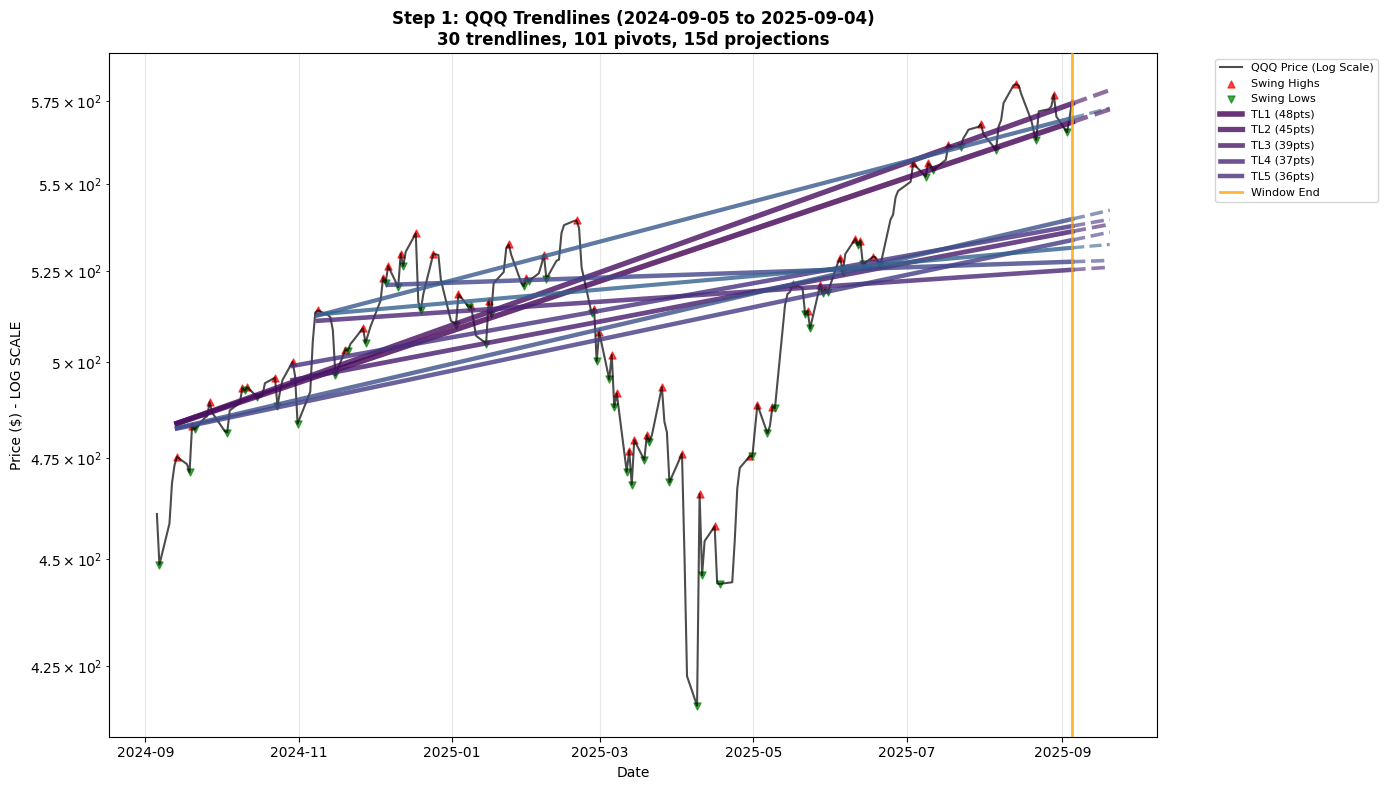

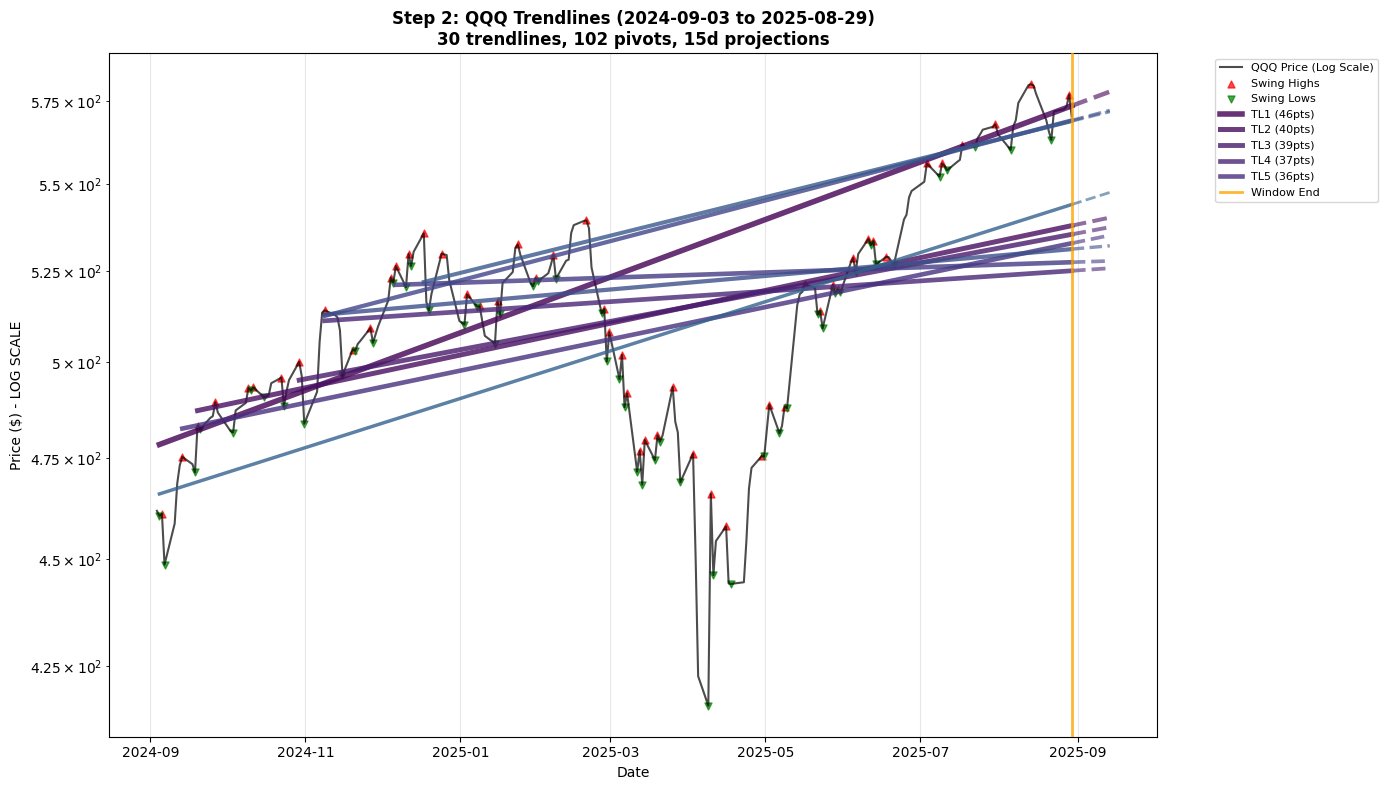

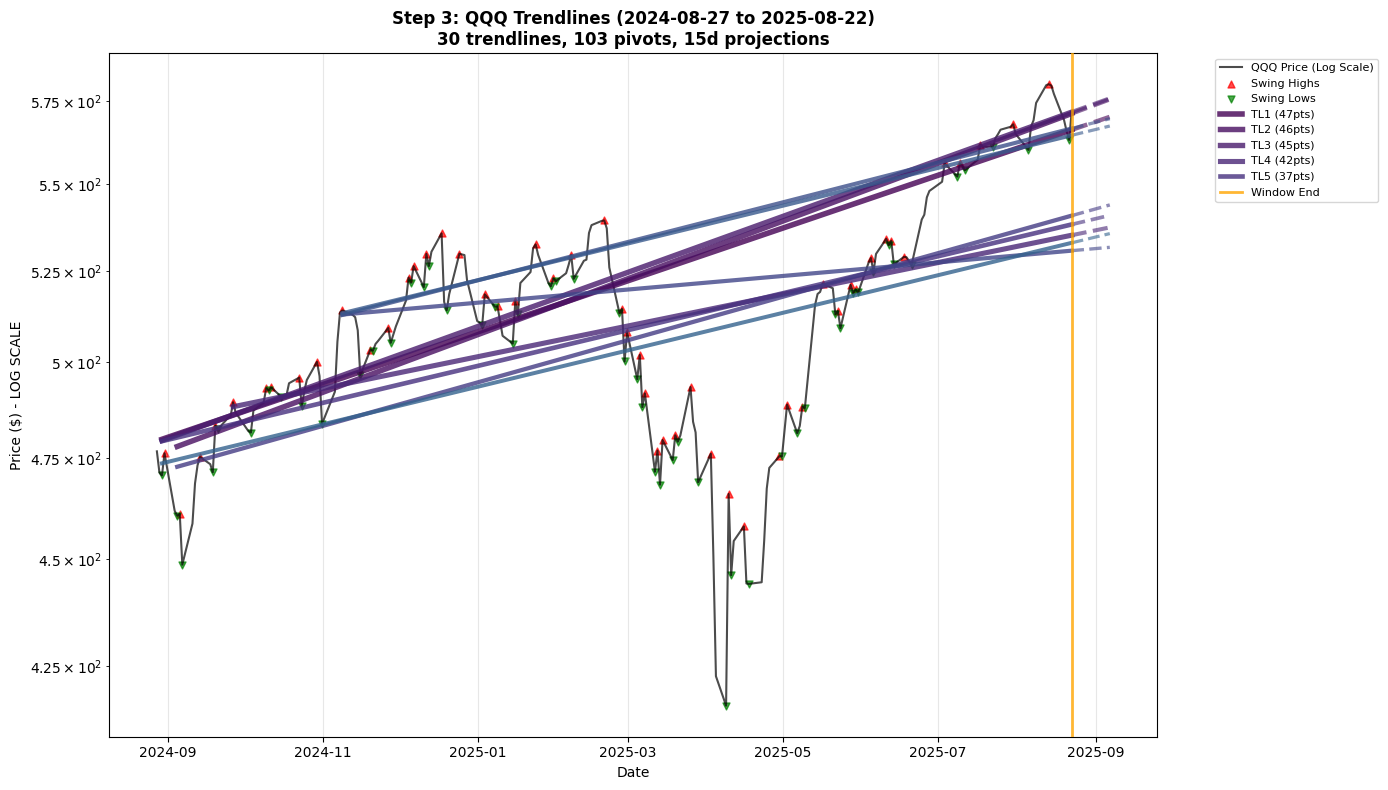

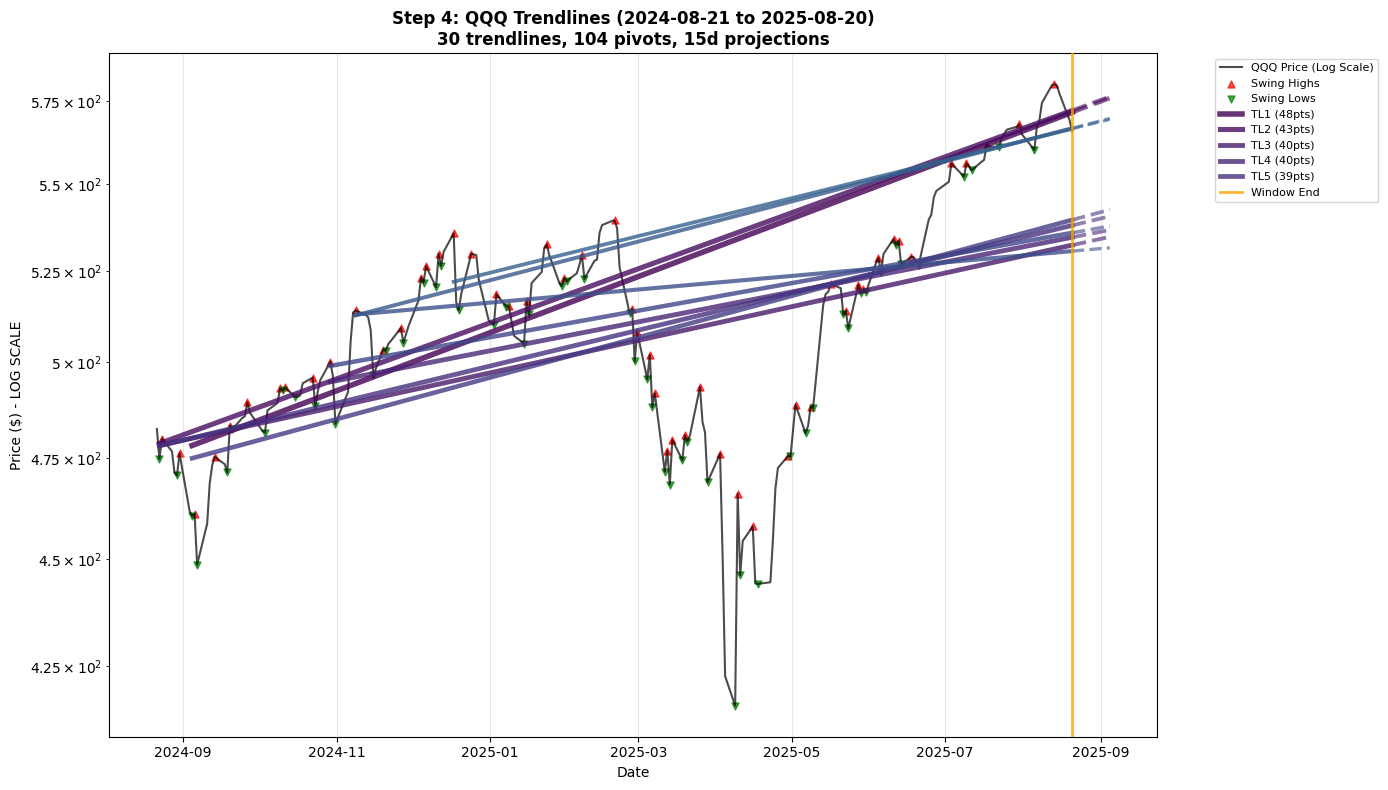

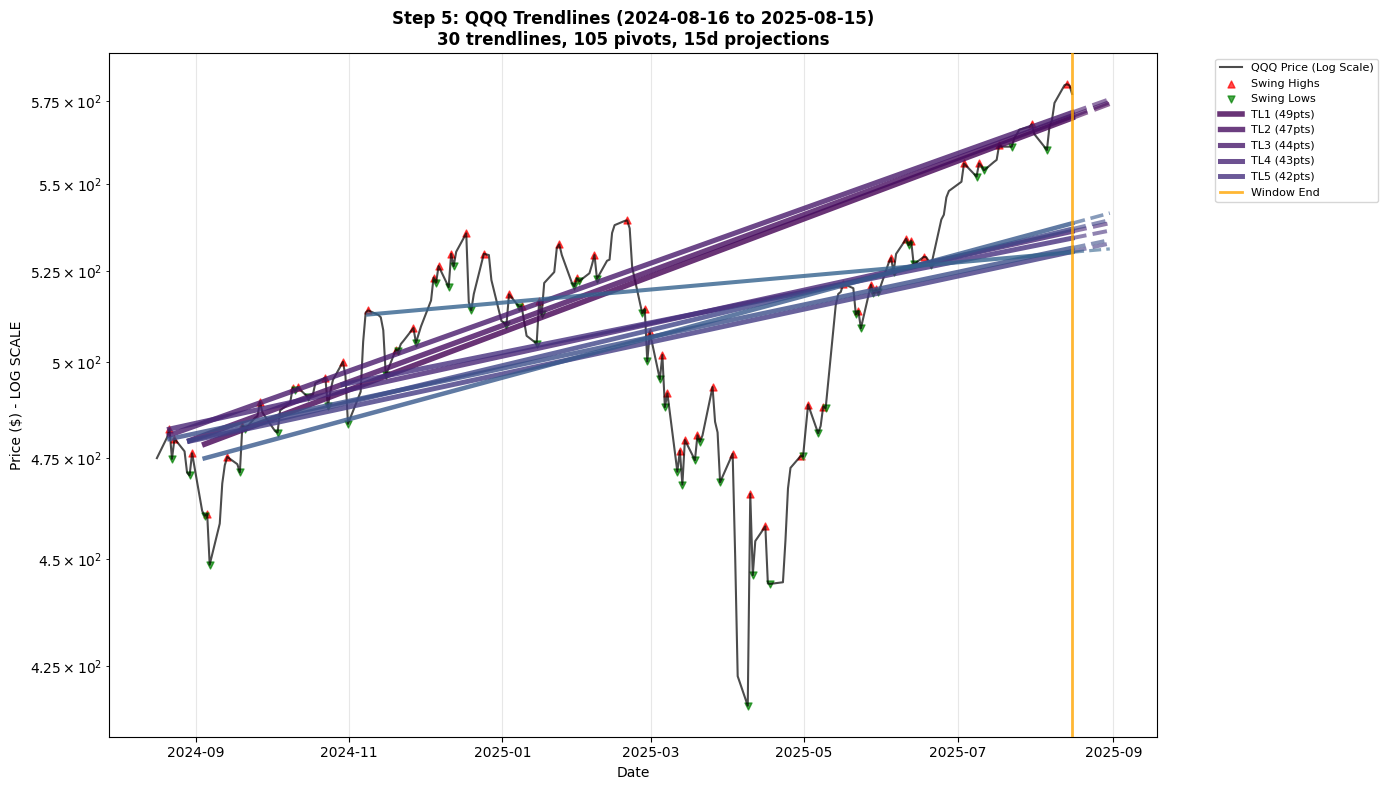

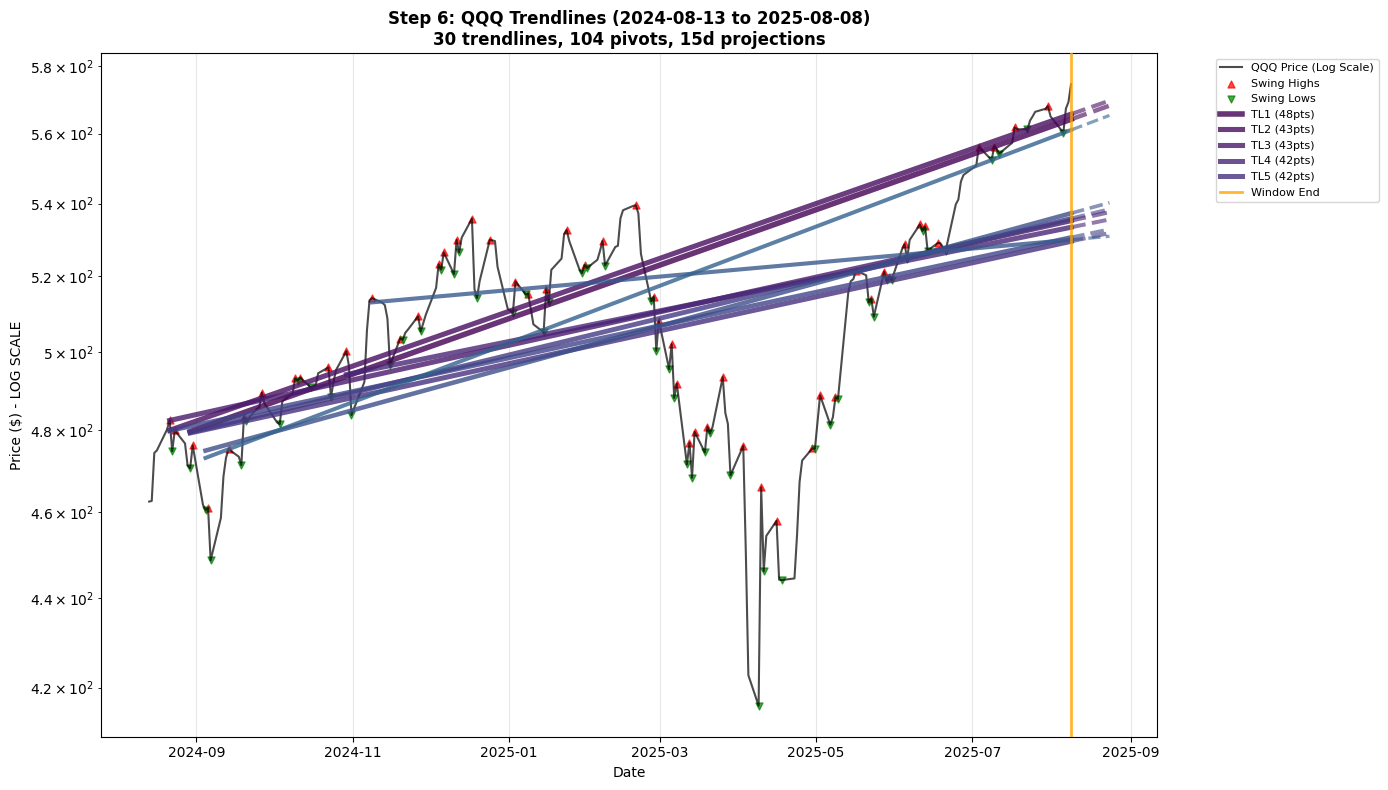

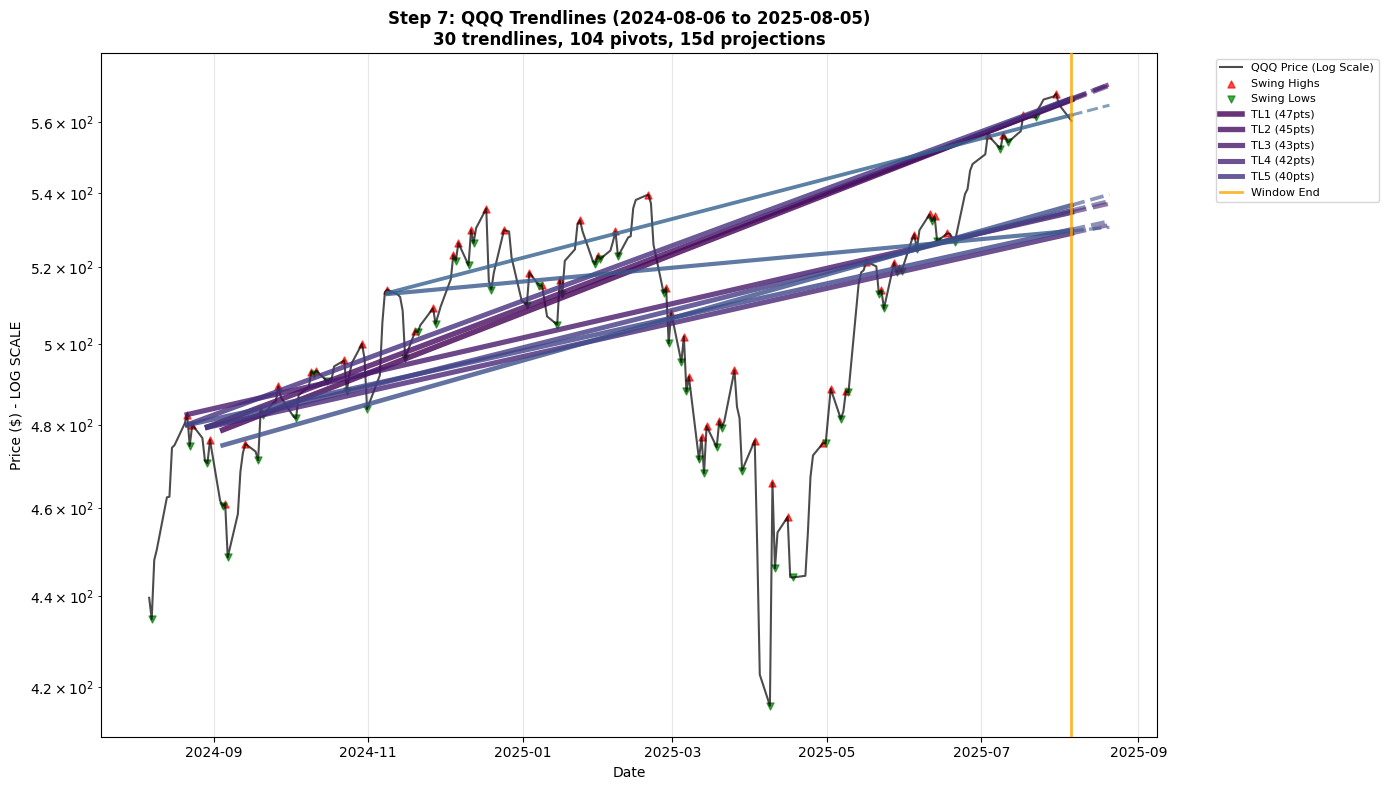

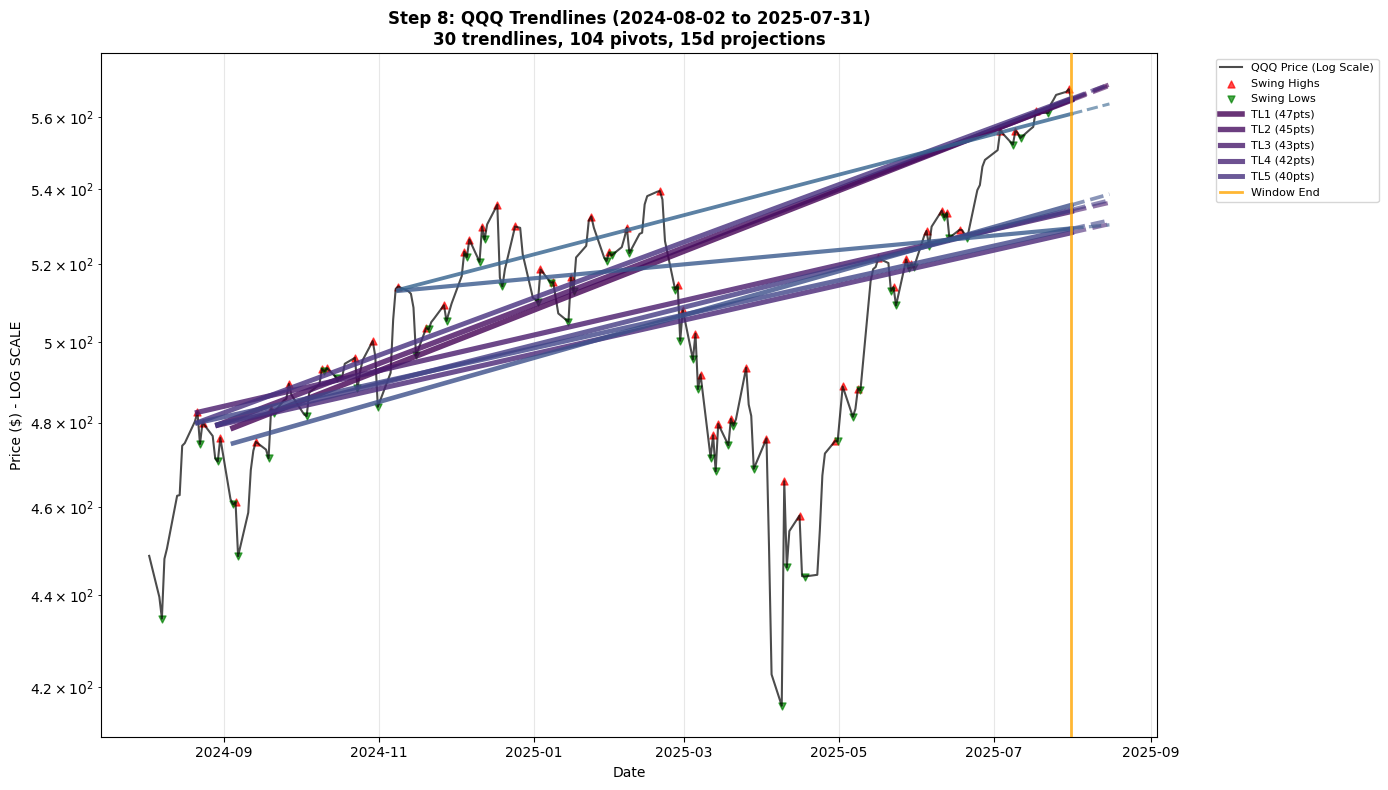

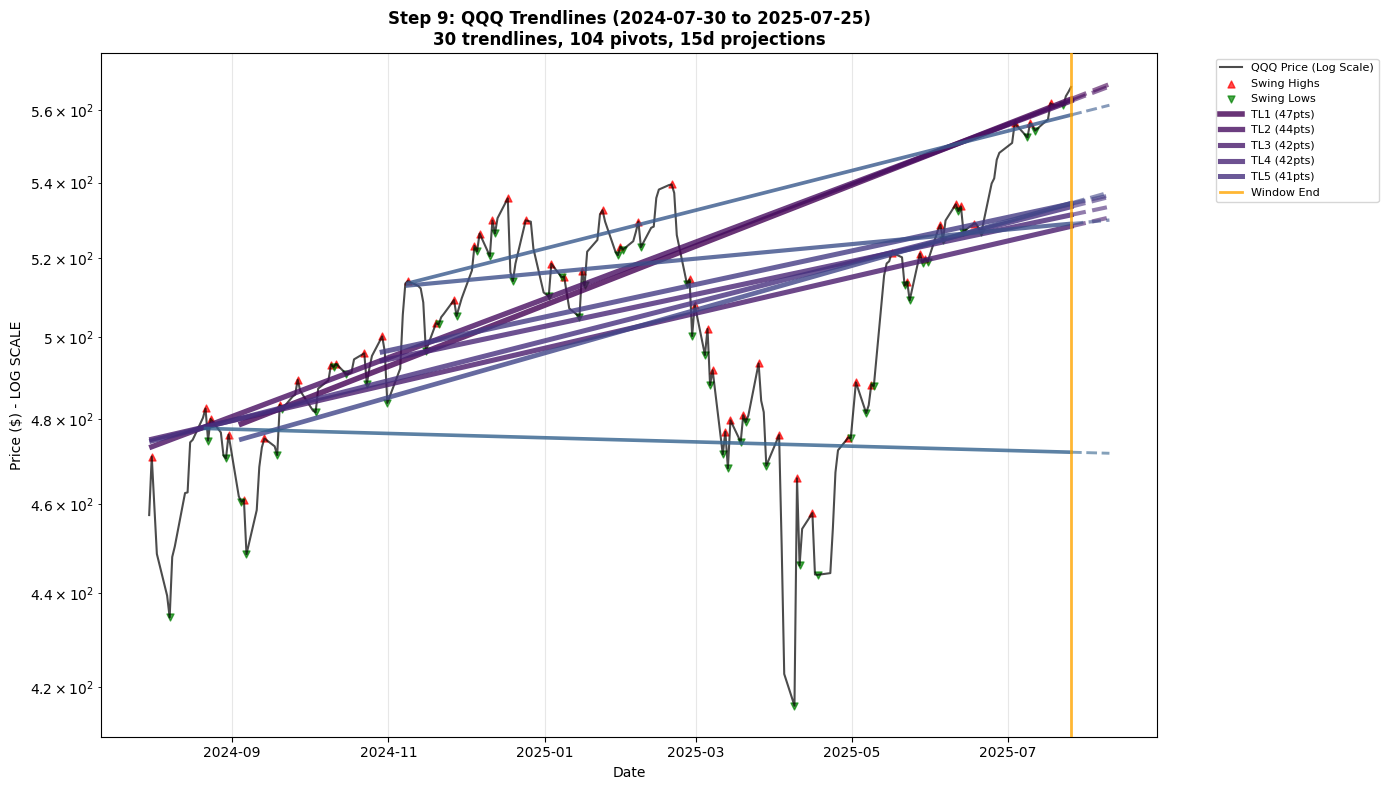

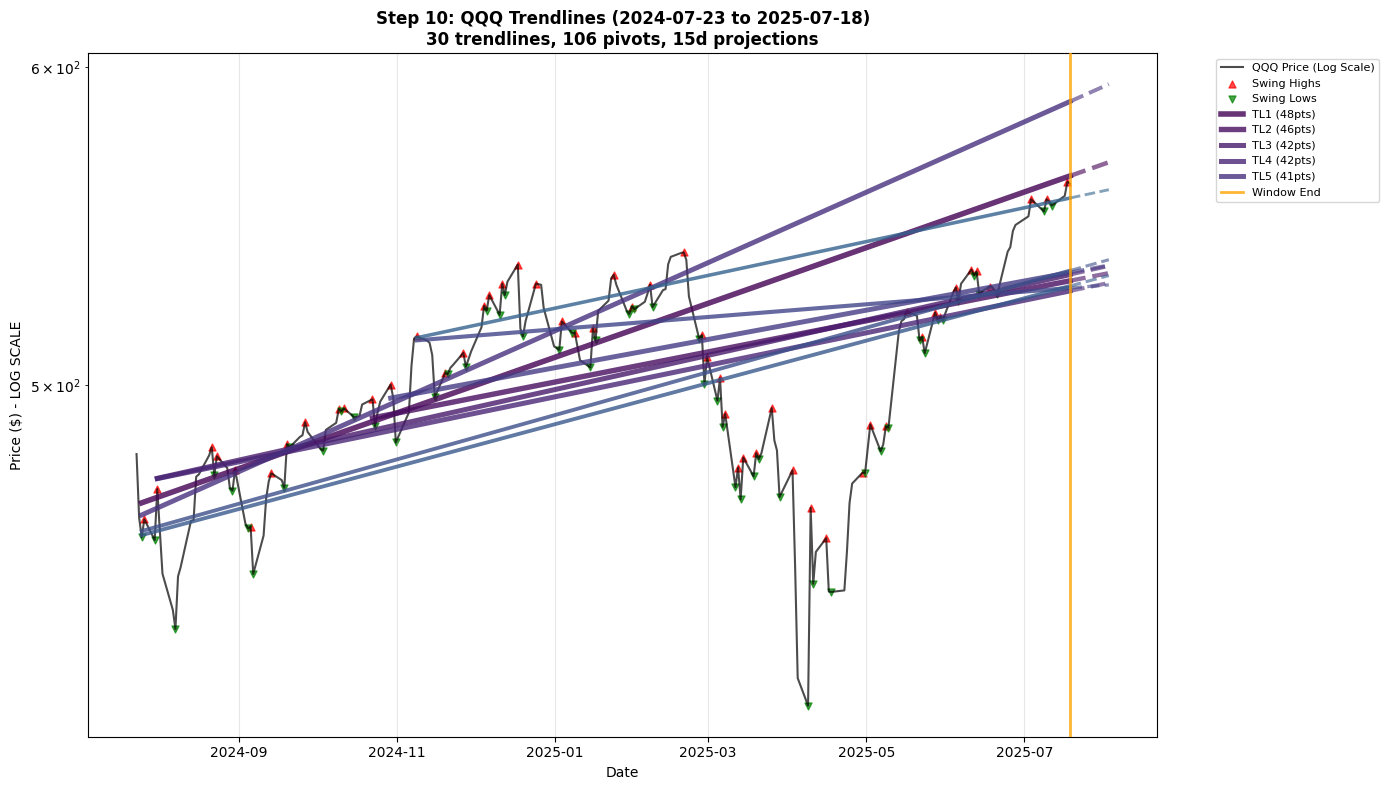

In [44]:
# Generate Charts for All Rolling Windows
print(f"📈 Generating trendline charts for all {len(rolling_results)} rolling windows...")
print(f"\n🎯 Each chart shows:")
print(f"   • {WINDOW_SIZE}-day price history (LOG SCALE)")
print(f"   • Detected pivot points (highs/lows)")
print(f"   • Top {MAX_TRENDLINES} trendlines (thickness = strength)")
print(f"   • {PROJECTION_DAYS}-day forward projections (dashed lines)")
print(f"   • Window boundaries and statistics")

print(f"\n" + "="*80)
print(f"🚀 ROLLING WINDOW TRENDLINE CHARTS")
print("="*80)

# Plot each rolling window
for i, result in enumerate(rolling_results):
    print(f"\n📊 WINDOW {result['step']}/{len(rolling_results)}")
    print(f"📅 Period: {result['window_start_date']} to {result['window_end_date']} ({WINDOW_SIZE} days)")

    plot_window_trendlines(result, PROJECTION_DAYS)

print(f"✅ Completed all {len(rolling_results)} rolling window visualizations!")

,Step,End Date,Trendlines,Avg Growth %/day,Max Strength,Bullish Ratio,Final Price $
0,1,2025-09-04,30,0.0086,48,0.63,575.23
1,2,2025-08-29,30,0.0047,46,0.60,570.40
2,3,2025-08-22,30,0.0216,47,0.73,571.97
3,4,2025-08-20,30,0.0084,48,0.60,565.90
4,5,2025-08-15,30,0.0134,49,0.70,577.34
5,6,2025-08-08,30,0.0132,48,0.70,574.55
6,7,2025-08-05,30,0.0140,47,0.70,560.27
7,8,2025-07-31,30,0.0140,47,0.70,565.01
8,9,2025-07-25,30,0.0120,47,0.63,566.37
9,10,2025-07-18,30,0.0127,48,0.63,561.26


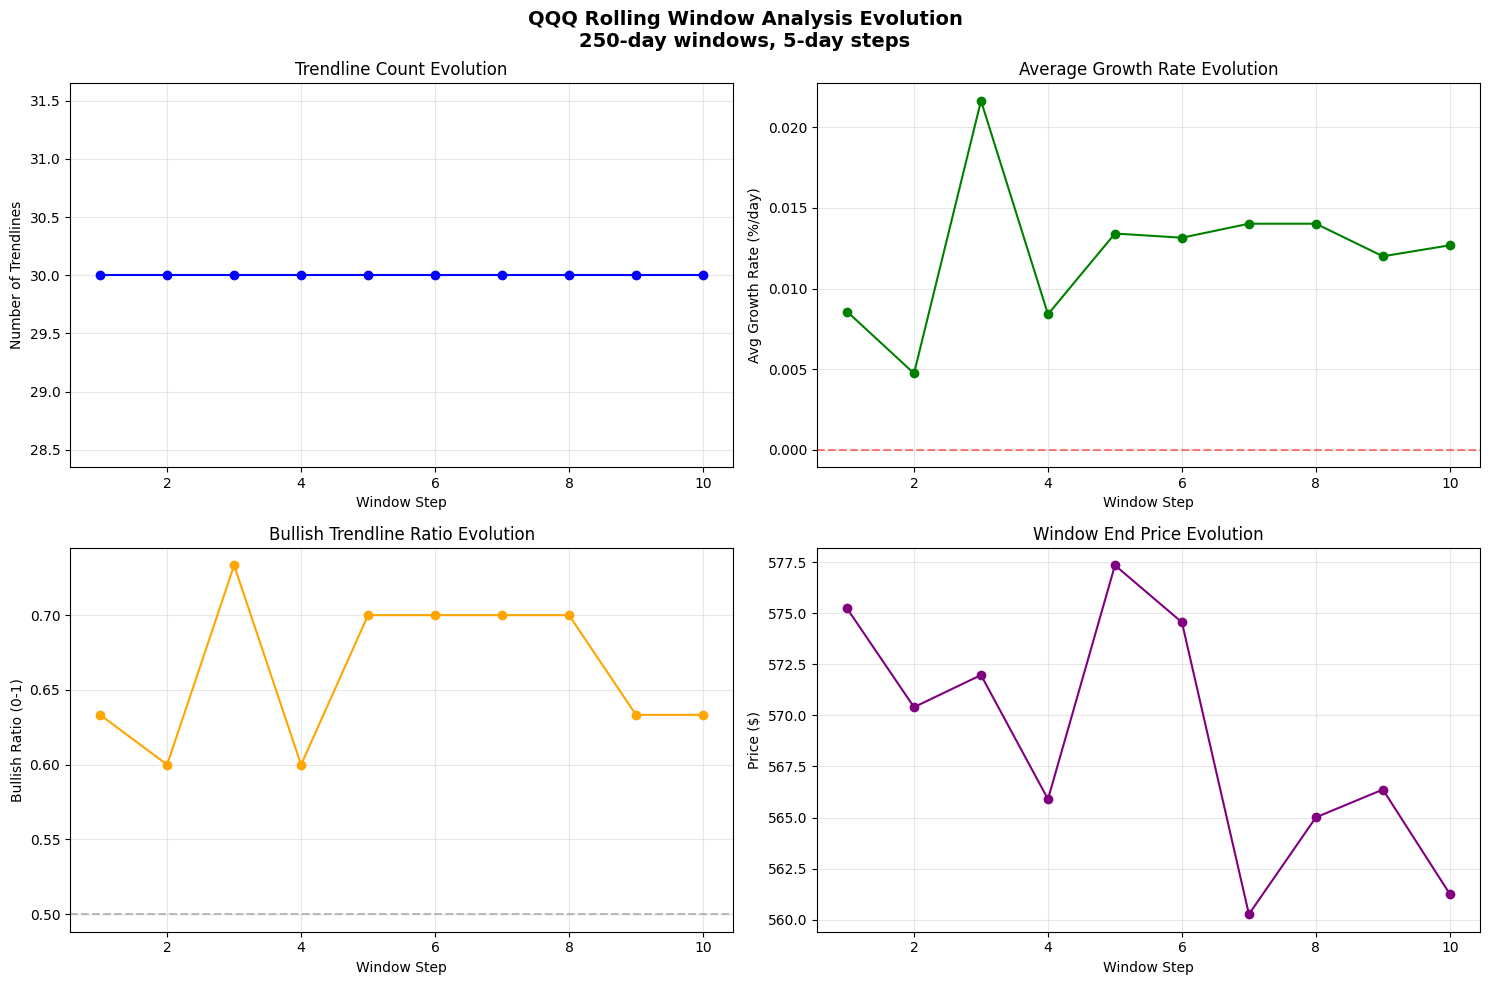

In [45]:
# Evolution Analysis - Compare Windows Over Time
print("🔄 Rolling Window Evolution Analysis")
print("="*50)

if len(rolling_results) > 1:
    # Track metrics over time
    evolution_data = []

    for result in rolling_results:
        if result['powerful_trendlines']:
            trendlines = result['powerful_trendlines']
            growth_rates = [tl['daily_growth_rate'] for tl in trendlines]
            strengths = [tl['strength'] for tl in trendlines]

            evolution_data.append({
                'step': result['step'],
                'window_end_date': result['window_end_date'],
                'trendline_count': len(trendlines),
                'avg_growth_rate': np.mean(growth_rates),
                'max_growth_rate': max(growth_rates),
                'min_growth_rate': min(growth_rates),
                'avg_strength': np.mean(strengths),
                'max_strength': max(strengths),
                'bullish_ratio': len([g for g in growth_rates if g > 0]) / len(growth_rates),
                'final_price': result['window_data']['Price'].iloc[-1]
            })

    evolution_df = pd.DataFrame(evolution_data)

    # Display evolution table
    display_df = evolution_df[['step', 'window_end_date', 'trendline_count', 'avg_growth_rate',
                              'max_strength', 'bullish_ratio', 'final_price']].copy()
    display_df.columns = ['Step', 'End Date', 'Trendlines', 'Avg Growth %/day',
                         'Max Strength', 'Bullish Ratio', 'Final Price $']
    display_df['Avg Growth %/day'] = display_df['Avg Growth %/day'].apply(lambda x: f"{x:.4f}")
    display_df['Bullish Ratio'] = display_df['Bullish Ratio'].apply(lambda x: f"{x:.2f}")
    display_df['Final Price $'] = display_df['Final Price $'].apply(lambda x: f"{x:.2f}")

    print("📊 Evolution Summary:")
    display(display_df)

    # Plot evolution metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Trendline count over time
    axes[0,0].plot(evolution_df['step'], evolution_df['trendline_count'], 'o-', color='blue')
    axes[0,0].set_title('Trendline Count Evolution')
    axes[0,0].set_xlabel('Window Step')
    axes[0,0].set_ylabel('Number of Trendlines')
    axes[0,0].grid(True, alpha=0.3)

    # Average growth rate over time
    axes[0,1].plot(evolution_df['step'], evolution_df['avg_growth_rate'], 'o-', color='green')
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Average Growth Rate Evolution')
    axes[0,1].set_xlabel('Window Step')
    axes[0,1].set_ylabel('Avg Growth Rate (%/day)')
    axes[0,1].grid(True, alpha=0.3)

    # Bullish ratio over time
    axes[1,0].plot(evolution_df['step'], evolution_df['bullish_ratio'], 'o-', color='orange')
    axes[1,0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1,0].set_title('Bullish Trendline Ratio Evolution')
    axes[1,0].set_xlabel('Window Step')
    axes[1,0].set_ylabel('Bullish Ratio (0-1)')
    axes[1,0].grid(True, alpha=0.3)

    # Final price over time
    axes[1,1].plot(evolution_df['step'], evolution_df['final_price'], 'o-', color='purple')
    axes[1,1].set_title('Window End Price Evolution')
    axes[1,1].set_xlabel('Window Step')
    axes[1,1].set_ylabel('Price ($)')
    axes[1,1].grid(True, alpha=0.3)

    plt.suptitle(f'{SYMBOL} Rolling Window Analysis Evolution\n'
                f'{WINDOW_SIZE}-day windows, {STEP_SIZE}-day steps', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary insights
    print(f"\n🔍 Key Insights:")
    print(f"   📈 Trendline count range: {evolution_df['trendline_count'].min()} - {evolution_df['trendline_count'].max()}")
    print(f"   📊 Avg growth rate range: {evolution_df['avg_growth_rate'].min():.4f} - {evolution_df['avg_growth_rate'].max():.4f} %/day")
    print(f"   🎯 Most bullish window: Step {evolution_df.loc[evolution_df['bullish_ratio'].idxmax(), 'step']} ({evolution_df['bullish_ratio'].max():.2f} bullish ratio)")
    print(f"   📉 Most bearish window: Step {evolution_df.loc[evolution_df['bullish_ratio'].idxmin(), 'step']} ({evolution_df['bullish_ratio'].min():.2f} bullish ratio)")

else:
    print("⚠️ Need at least 2 windows for evolution analysis")

print(f"\n✅ Rolling window analysis complete!")

## Rolling Window Analysis Summary

This notebook successfully performed rolling window trendline analysis with the following approach:

### 📊 Analysis Method
- **Window Size**: 250 trading days per analysis window
- **Step Size**: 5-day forward movement between windows
- **Total Windows**: 10 overlapping analysis periods
- **Trendlines**: Top 20 LOG SCALE trendlines per window
- **Projections**: 15-day forward projections for each window

### 🎯 Key Features
1. **Modular Architecture**: Used extracted scripts without verbose logging
2. **LOG SCALE Analysis**: Percentage-based trendline detection
3. **Rolling Evolution**: Track how trendlines evolve as new data becomes available
4. **Visual Analysis**: Individual charts for each window with projections
5. **Evolution Metrics**: Track changes in trendline patterns over time

### 📈 Output Components
- **Individual Charts**: Each window shows price, pivots, trendlines, and projections
- **Evolution Analysis**: Metrics tracking over the rolling windows
- **Summary Statistics**: Growth rates, strengths, and bullish/bearish ratios
- **Trend Insights**: Key patterns and changes across windows

### 🔄 Applications
This rolling window approach is valuable for:
- **Strategy Development**: Understanding how trendlines evolve with new data
- **Risk Management**: Tracking changes in market sentiment and trend strength
- **Signal Generation**: Identifying when trendline patterns shift significantly
- **Backtesting**: Historical analysis of trendline performance across different periods

The analysis provides both detailed individual window insights and broader evolution patterns, making it a powerful tool for dynamic trendline analysis.